In [988]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


In [989]:
# Features
# X = ['GDPPerCapita', 'CostOfSolar', 'CostOfBatt', 'Population]
# Y = Solar MW Installed

In [990]:
techcostvar = "Solar_Generation_Cost_USD_MW"
battscenario = "Mid_Bat_Cost_USD_MW"

In [991]:
years = ["2000","2012","2013","2014","2015","2016","2017","2018","2019"]

Popfp = '.\Data\PopAndGDP\Population.csv'
Pop = pd.read_csv(Popfp, encoding = "utf-8")
Pop = Pop.melt(id_vars=["Country", "Country Code"], var_name="Year", value_name="population")
Pop["Year"] = Pop["Year"].apply(pd.to_numeric, errors='coerce')

GDPfp = '.\Data\PopAndGDP\GDPPerCapita.csv'
GDP = pd.read_csv(GDPfp, encoding = "utf-8")
GDP = GDP.melt(id_vars=["Country", "Country Code"], var_name="Year", value_name="GDP_Per_Capita")
GDP["Year"] = GDP["Year"].apply(pd.to_numeric, errors='coerce')

TechCostfp = '.\Data\SolarWindConstructionCost\SolarWindConstructionCost.csv'
TechCost = pd.read_csv(TechCostfp, encoding="utf-8")
TechCost = TechCost.apply(pd.to_numeric, errors='coerce')

SolarCost = TechCost[["Year", techcostvar]]
BattCost = TechCost[["Year", battscenario]]

Installedatasetp = '.\Data\InstalledCapacity\RECAP_20220519-053554.csv'
Installed = pd.read_csv(Installedfp, encoding = "ISO-8859-1")
Installed = Installed[Installed.Technology == "Solar"]
Installed = Installed.melt(id_vars=["Country", "Technology"], var_name="Year", value_name="Installed_Solar_Capacity")
Installed["Year"] = Installed["Year"].apply(pd.to_numeric, errors='coerce')

In [992]:
X_params = ["population", "GDP_Per_Capita",techcostvar,battscenario]
Y_param = ["Installed_Solar_Capacity"]

dataset = pd.merge(Pop, GDP)
dataset = dataset.merge(SolarCost, on="Year")
dataset = dataset.merge(BattCost, on="Year")
dataset = dataset.merge(Installed, on=["Country", "Year"])


In [993]:

dataset.replace('..', np.nan, inplace=True)
dataset = dataset[X_params + Y_param].dropna()
dataset = dataset.apply(pd.to_numeric, errors='coerce')
dataset = dataset[dataset['GDP_Per_Capita'] <= 15000]


#dataset.Installed_Solar_Capacity = dataset.Installed_Solar_Capacity/dataset.GDP_Per_Capita
#dataset=(dataset-dataset.mean())/dataset.std()
#dataset=(dataset-dataset.min())/(dataset.max()-dataset.min())
dataset.head()

,population,GDP_Per_Capita,Solar_Generation_Cost_USD_MW,Mid_Bat_Cost_USD_MW,Installed_Solar_Capacity
0,0.004,0.028,1.000,1.000,0.000
1,0.000,0.272,1.000,1.000,0.000
2,0.005,0.363,1.000,1.000,0.000
4,0.003,0.330,1.000,1.000,0.000
5,0.005,0.870,1.000,1.000,0.000


In [994]:
X_train, X_test, y_train, y_test = train_test_split(dataset[X_params],dataset[Y_param],test_size=0.5,random_state=42)

In [995]:
#sns.pairplot(train_dataset[X_params], diag_kind='kde')


Normalization

In [996]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())


[[0.01832504 0.31679896 0.50260454 0.49009144]]


In [997]:
print(X_test.columns, '\n',y_test.columns)

Index(['population', 'GDP_Per_Capita', 'Solar_Generation_Cost_USD_MW',
       'Mid_Bat_Cost_USD_MW'],
      dtype='object') 
 Index(['Installed_Solar_Capacity'], dtype='object')


DNN

In [998]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      #norm,
      layers.Dense(4, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(20, activation='relu'),
      layers.Dense(20, activation='relu'),
      layers.Dense(10, activation='relu'),
      layers.Dense(5, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                #optimizer=tf.keras.optimizers.Adam(),
                )
  return model

dnn_model = build_and_compile_model(normalizer)

  

In [999]:
#create a learning rate callback
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-3 *10**(epoch/20) )
#dnn_model.summary()
#%%time
epoch_num = 500
history = dnn_model.fit(
    X_train,
    y_train,
    #callbacks=[lr_scheduler],
    validation_data=(X_test,y_test),
    verbose=1, 
    epochs=epoch_num)

Epoch 1/500
16/16 [==============================] - 1s 17ms/step - loss: 0.0121 - val_loss: 0.0039
Epoch 2/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0092 - val_loss: 0.0036
Epoch 3/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0036
Epoch 4/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0037
Epoch 5/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0036
Epoch 6/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0090 - val_loss: 0.0037
Epoch 7/500
16/16 [==============================] - 0s 5ms/step - loss: 0.0091 - val_loss: 0.0037
Epoch 8/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0091 - val_loss: 0.0036
Epoch 9/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0037
Epoch 10/500
16/16 [==============================] - 0s 4ms/step - loss: 0.0090 - val_loss: 0.0036
Epoch 11

https://www.weforum.org/agenda/2021/11/renewable-energy-cost-fallen/#:~:text=Back%20in%202010%2C%20a%20megawatt,been%20applicable%20in%20some%20areas.
https://www.windpowermonthly.com/article/1713420/windeconomics-fall-fall-wind-solar-costs
https://www.nrel.gov/docs/fy21osti/79236.pdf

In [1000]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

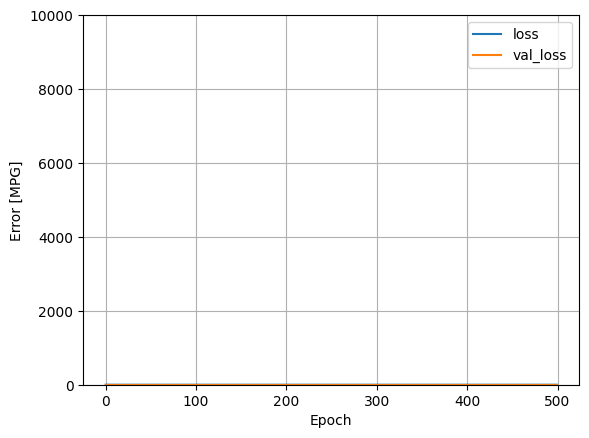

In [1001]:
plot_loss(history)

In [1002]:
y = dnn_model.predict(X_test)

16/16 [==============================] - 0s 2ms/step


Text(0.5, 1.0, 'Finding the ideal Learning Rate')

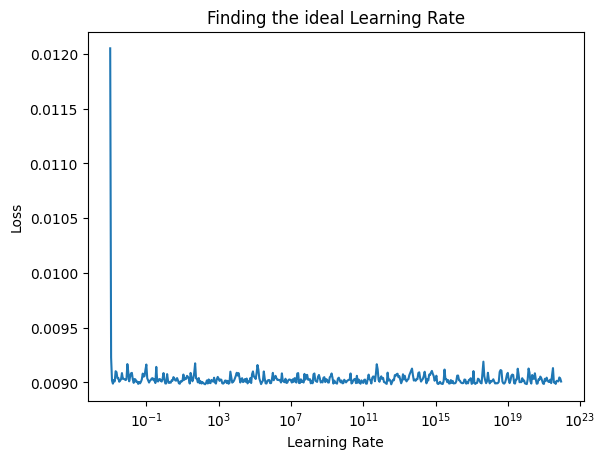

In [1003]:
import matplotlib.pyplot as plt

lrs =1e-3 *(10**(tf.range(epoch_num)/20))
plt.semilogx(lrs,history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Finding the ideal Learning Rate")

In [1004]:
test_results ={}
test_results['linear_model'] = dnn_model.evaluate(
    X_test, y_test, verbose=0)
test_results

{'linear_model': 0.0036222818307578564}

In [1005]:
test_predictions = dnn_model.predict(X_test).flatten()
test_predictions
print(0, max(test_predictions))

16/16 [==============================] - 0s 1ms/step
0 -5.8435086e-05


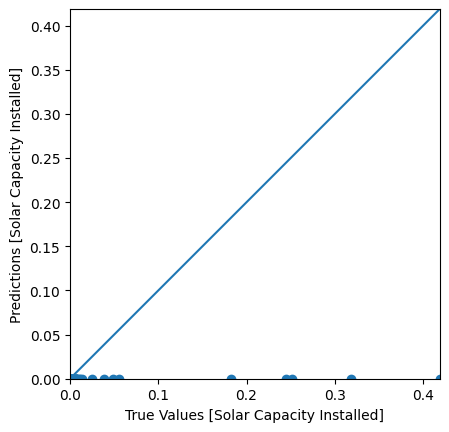

In [1006]:
a = plt.axes(aspect='equal')
#plt.scatter(y_test.Installed_Solar_Capacity*X_test.population, test_predictions*X_test.population)
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [Solar Capacity Installed]')
plt.ylabel('Predictions [Solar Capacity Installed]')
lims = [0, max(y_test.Installed_Solar_Capacity)]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [1007]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test.Installed_Solar_Capacity*X_test.population, test_predictions*X_test.population)

0.000629146567290699

In [1008]:
result = pd.DataFrame(test_predictions*X_test.population)
result["Installed Solar Capacity"] = y_test.Installed_Solar_Capacity*X_test.population
result = result.rename(columns={'population':'Predicted Installed Solar MW'})
#result = pd.DataFrame(test_predictions)
#result = result.join(y_test)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
result.head()
#result.to_csv("predictions.csv")

,Predicted Installed Solar MW,Installed Solar Capacity
905,-0.000,0.000
660,-0.000,0.000
1087,-0.000,0.000
642,-0.000,0.000
408,-0.000,0.000
